# Tutorial: Reinforcing Feedback Loops in Predictive Policing

In this tutorial we will analyze the problem of the amplification of unfairness through reinforcing feedback loops. Generally speaking, **reinforcing feedback loops** are feedback mechanisms that amplify an effect over time. In the context of fairness, historical bias present in data can be introduced or amplified over time. In particular, this type of feedback loop can occur when the predictions of the model affects which data is collected.

### Predictive Policing
We will explore reinforcing feedback loops in a *(highly stylized)* predictive policing scenario: predicting crime in order to better distribute police resources.

##### Historical Bias
In some countries, neighborhoods are highly segregated by race or ethnicity. As a result, even a seemingly neutral provision such as postal code can be highly correlated to these constructs. Fairness issues can arise when some neighborhoods are over-represented in crime databases due to racially biased policing practices, resulting in *historical bias* in the collected data. When biased crime records are used to make dispatching decisions, fairness-related harms such as allocation harm and quality-of-service harm can occur. 

##### Reinforcing Feedback Looop
The feedback loop occurs when the model's predictions affect new data collection. In the predictive policing scenario, this can occur when the model's prediction direclty affect dispatching decisions. When a disproportional number of police officers is dispatched to already over-represented neighborhoods, more crime will be discovered - simply because there are more police officers present. This increases over-representation of the neighborhood even further, reinforcing historical bias.

The problem of feedback loops in predictive policing has been analyzed in e.g. [1] and [2]. The analysis that we will do in this tutorial is inspired by the theoretical analysis of [1], although we will take an empirical approach using simulations.

##### References
1.  Danielle Ensign, Sorelle A. Friedler, Scott Neville, Carlos Scheidegger, and Suresh Venkatasubramanian. *Runaway feedback loops in predictive policing*. In Sorelle A. Friedler and Christoff Wilson, editors, Conference on Fairness, Accountability and Transparency, FAT 2018, 23-24 February 2018, New York, NY, USA, volume 81 of Proceedings of Machine Learning Research, pages 160{171. PMLR, 2018.
2. Kristian Lum and William Isaac. *To predict and serve?* Significance, 13(5):14{19, 2016.

In [11]:
import numpy as np
import pandas as pd
from simulation import Neighborhood, Model, Agent, Policy, Experiment
import matplotlib.pyplot as plt 

# this random number generator is used to generate seeds
prng = np.random.RandomState(seed=1) 

## The Simulation
We will explore the predictive policing scenario through a very simplified simulation.

The simulation considers a fictional city with a single police officer who polices two neighborhoods. Every day, the police officer is sent to a neighborhood according to a dispatching schedule. If the police officer discovers a drug use incident, it is logged as a discovered incident. In addition, each neighborhood has a neighborhood watch who may report incidents, which are also logged as discovered incidents. 

Given the limited resources, we want to dispatch the police officer to the neighborhood in which the most crime occurs. In order to do so, the city council has asked a data scientist to build a predictive model that predicts the number of incidents in each neighborhood. Then, the officer can be dispatched to the neighborhood for which the most crime is predicted. 

Because we analyze the problem using a simulation, we can track both the data that would have been collected in real life (discovered incidents) as well as the ground truth (actual incidents).

### Implementation
The simulation is implemented using the following classes.
* The `Neighborhood` class represents a simulated neighborhood. The class has the following initialization parameters:

    * `name` : name of the neighborhood
    * `mean_daily` : the average number of daily drug use incidents in the neighborhood. Daily drug usage will be simulated according to a Poisson discrete random variable with `mean_daily` as mean/variance.
    * `historic_discovery_rate` : proportion of actual incidents that have been discovered historically in this neighborhood
    * `history_length` : number of days of historic data with which we initialize the simulation


* The `Model` class represents our predictive model. In this simulation, we use an extremely simple time series forecasting model that predicts the number of crimes in a region, based on the average number of previous daily incidents.

* An `Agent` represents an actor in the simulation who can discover crime. We have two different types of agents (`agent_type` parameter): police officer (`'officer'`) or neighborhood watch (`'watch'`). In addition, we can define the effectiveness of an `Agent` using the `discovery_rate` parameter (between 0 and 1). The discoveries are simulated using a bernoulli discrete random variable with success probability equal to `discovery_rate`. 

* The `Policy` class implements the policy for dispatching agents to neighborhoods, based on the output of the prediction model. In the simple scenario that we consider in this tutorial, we simply dispatch the police officer to the neighborhood with the highest number of predicted crime.
* We can run a simulation experiment using the `Experiment` class. The parameters of this class include a list of all `Neighborhood`s, `Agent`s, the predictive `Model`, the dispatching `Policy`, and the number of days we want to simulate `n_epochs`.

## Example Run : Feedback Loop at Work

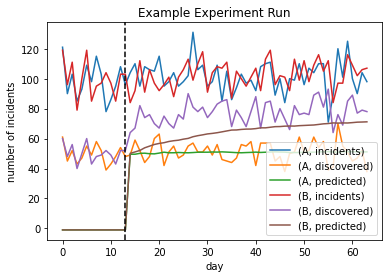

In [12]:
n_epochs = 50 # we see what happens when we use this model and policy for 100 days
history_length = 14

# initialize model, policy, neighborhoods and agents
model = Model() # our simple moving average predictive model
policy = Policy(dispatch_type='basic') # we use a basic dispatching policy
neighborhoods = [
        Neighborhood(name='A', mean_daily=100, historic_discovery_rate=0.5, history_length=history_length, seed=prng.randint(0,1000)), 
        Neighborhood(name='B', mean_daily=100, historic_discovery_rate=0.5, history_length=history_length, seed=prng.randint(0,1000)),]
agents = [
        Agent(name='Harry', agent_type='officer', discovery_rate=0.5, seed=prng.randint(0,1000)),
        Agent(name='NightsWatchA', agent_type='watch', discovery_rate=0.5, seed=prng.randint(0,1000), neighborhood_name='A'),
        Agent(name='NightsWatchB', agent_type='watch', discovery_rate=0.5, seed=prng.randint(0,1000), neighborhood_name='B'),]

# define experiment
exp = Experiment(neighborhoods, agents, Model(), Policy(dispatch_type='basic'), n_epochs=n_epochs)
result_example = pd.DataFrame(exp.run())

# plot results
result_example.plot(title="Example Experiment Run")
plt.xlabel('day')
plt.ylabel('number of incidents')
plt.legend(loc='lower right')
plt.axvline(x=history_length-1, c='black', ls='--')
plt.show()

We can see the feedback loop at work immediately after we start using our predictive model (after the dashed line). The predicted incidents in neighborhood A stay constant, whereas the number of predicted incidents in neighborhood B increases over time. 

Note that this loop occurs **even though the initial discovery rate is the same for each neighborhood!** The reason for this is that, by chance, the predicted crime rate was slightly higher in neighborhood *B*. Consequently, the police officer was dispatched to his neighborhood, causing the number of discovered incidents to go up. As our model's predictions depend on the number of discovered incidents, the number of predicted incidents for neighborhood *B* increases as well.

### Measuring Predictive Performance and Fairness

We can evaluate the performance of the prediction model for each day based on how many of the observed or actual incidents we predicted.
* The **observed** performance can be computed as the number of predicted incidents over the number of discovered incidents.
$$observed = \frac{predicted}{discovered}$$

* The **actual** performance can be computed as the number of predicted incidents over the number of actual incidents.
$$actual = \frac{predicted}{actual}$$

Note that our dispatching policy is directly related to the prediction of our model. We can consider **quality-of-service harm** by taking the difference between the performance between the two neighborhoods. We can compute both the *observed* and *actual* disparity.

In [13]:
def evaluate_result(result, history_length):
    """
    Compute OAE, AAE, OAE_diff and AAE_diff of an experiment run.
    result : dict
        results of the experiment run
    history_length : int
        The history length that was used in the experiment. Is used to ensure that we only evaluate
        the days since we use our model. 
    """
    result = pd.DataFrame(result)
    # Sum incidents, discovered incidents, and predicted incidents per day.
    result_total = result.stack(level=0).sum(level=0)
    
    # Compute overall observed and actual absolute error per day
    observed = np.array(result_total['predicted'] / result_total['discovered'])
    actual = np.array(result_total['predicted'] / result_total['incidents'])

    # Difference in observed absolute error
    observed_A = (result['A']['predicted'] / result['A']['discovered'])
    observed_B = (result['B']['predicted'] / result['B']['discovered'])
    observed_diff = np.array((observed_A - observed_B).abs())

    # Difference in actual absolute error
    actual_A = (result['A']['predicted'] / result['A']['incidents'])
    actual_B = (result['B']['predicted'] / result['B']['incidents'])
    actual_diff = np.array((actual_A - actual_B).abs())
    
    return {'Observed Proportion' : observed[history_length:].mean(), 
            'Actual Proportion' : actual[history_length:].mean(), 
            'Disparity (Observed)' : observed_diff[history_length:].mean(), 
            'Disparity (Actual)' : actual_diff[history_length:].mean()}

In [14]:
evaluate_result(result_example, history_length)

{'Observed Proportion': 0.901281759593239,
 'Actual Proportion': 0.5674598338935627,
 'Disparity (Observed)': 0.1914434803146128,
 'Disparity (Actual)': 0.134294581327065}

The computed metrics summarize what we observed in the previous plot.

## Experiment Set 1: Uniform Crime Rates
In this experiment, we will explore the effect of differences in historic discovery rate between the two neighborhoods. 
* We keep the historic discovery rate of neighborhood A fixed to 0.5, indicating that historically, each incident had a probability of 0.5 to be discovered.
* We vary the historic discovery rate of neighborhood B from 0 to 1.

In [17]:
reps = 100 # we repeat each experiment multiple times to estimate the effect across multiple runs with the same setting
n_epochs = 30 # we see what happens when we use this model and policy for 100 days
historic_discovery_rates = np.linspace(0, 1, num=9)

In [18]:
results_1 = [None] * len(historic_discovery_rates)*reps
i = 0
for historic_discovery_rate_B in historic_discovery_rates:
    # initialize neighborhoods
    neighborhoods = [
        Neighborhood(name='A', mean_daily=100, historic_discovery_rate=0.5, history_length=14, seed=prng.randint(0,1000)),
        Neighborhood(name='B', mean_daily=100, historic_discovery_rate=historic_discovery_rate_B, history_length=14, seed=prng.randint(0,1000)),]
    # initialize agents
    agents = [
        Agent(name='Harry the Police Officer', agent_type='officer', discovery_rate=0.5, seed=prng.randint(0,1000)),
        Agent(name='NightsWatch A', agent_type='watch', discovery_rate=0.5, seed=prng.randint(0,1000), neighborhood_name='A'),
        Agent(name='NightsWatch B', agent_type='watch', discovery_rate=0.5, seed=prng.randint(0,1000), neighborhood_name='B'),]
    # run experiment
    for rep in range(reps):
        # define experiment
        exp = Experiment(neighborhoods, agents, Model(), Policy(dispatch_type='basic'), n_epochs=n_epochs)
        # run and evaluate experiment
        result = evaluate_result(exp.run(), history_length)
        # add metadata
        result['historic discovery rate (B)'] = historic_discovery_rate_B
        results_1[i] = result
        i+=1

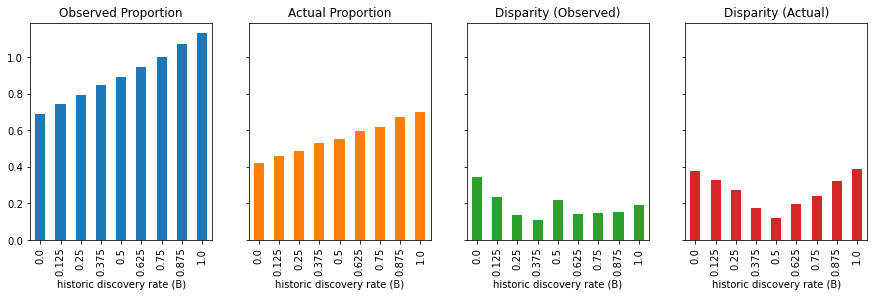

In [19]:
# visualize results
pd.DataFrame(results_1).groupby('historic discovery rate (B)').mean().plot(kind='bar', figsize=(15,4), 
                                                                         subplots=True, layout=(1,4), 
                                                                         legend=False, sharey=True)
plt.show()

We can make several observations from these results.

### Performance
*Both the observed proportion and actual proportion increase when the historic discovery rate increase.* This result can be explained by the fact that we will typically underestimate the number of discovered and actual incidents. When the historic discovery rate is higher in one of the neighborhoods, we will predict more crime in that neighborhood, which is closer to the observed/actual incidents.

*The observed proportion is higher than the actual proportion*. This makes sense: our predictions are based on past observed crime, but this is only a subset of actual crime. Note that, baed on the observed proportion, we seemingly *overshoot* our predictions when the historic discovery rate is higher than 0.75. The reason for this, is that the probability that crime is observed when the police officer is present is equal to 0.75 (indeed, the probability that crime is detected by neither the officer nor the neighborhood watch is 0.25). Consequently, our new dispatching policy cannot "keep up" with the historical discovery rate. Importantly, this is only a feature of the observed proportion; in reality, we still only observe a proportion of all crime.

### Fairness
*The actual disparity becomes larger when the historic discovery rate of neighborhood B differs more from neighborhood A*. When the historic discovery rate differs more, the officer will more often be dispatched to either neighborhod B (>0.5) or A (<0.5). Note that this occurs **even though the underlying crime rate between the two neighborhoods is equal**. 

*The observed disparity is smaller than the actual disparity, except when the historical discovery rates are qual across neighborhoods*. This is an important result: in the observed data, we usually underestimate the actual disparity -- particularly when the historic discovery rate in neighborhood B is higher. But in practice, we only have access to the observed data!

The underlying reason for these results is that the *observed* incidents are not an adequate representation of the *actual* incidents. In other words: this is a problem of **construct validity**. Moreover, the feedback loop will cause skewed base rates to be amplified over time this, amplifying the construct validity bias.

## Experiment Set 2: Different Crime Rates
Now lets consider the scenario in which the crime rate within the two neighborhoods is different
* First initialize the simulation with no former representation bias, using the same crime rate for each neighborhood. 
* Then, run several experiments in which you gradually increase the crime rate (mean daily) of one of the neighborhoods. Can you explain your results? What can you conclude about the effect of non-uniform crime rates on the feedback loop?

In [20]:
reps = 100
means_daily = np.linspace(100, 200, 9)

In [21]:
results_2 = [None] * len(means_daily)*reps
i = 0
for mean_daily_B in means_daily:
    # initialize neighborhoods
    neighborhoods = [
        Neighborhood(name='A', mean_daily=100, historic_discovery_rate=0.5, history_length=14, seed=prng.randint(0,1000)),
        Neighborhood(name='B', mean_daily=mean_daily_B, historic_discovery_rate=0.5, history_length=14, seed=prng.randint(0,1000)),]
    # initialize agents
    agents = [
        Agent(name='Harry the Police Officer', agent_type='officer', discovery_rate=0.5, seed=prng.randint(0,1000)),
        Agent(name='NightsWatch A', agent_type='watch', discovery_rate=0.5, seed=prng.randint(0,1000), neighborhood_name='A'),
        Agent(name='NightsWatch B', agent_type='watch', discovery_rate=0.5, seed=prng.randint(0,1000), neighborhood_name='B'),]
    # run experiment
    for rep in range(reps):
        # define experiment
        exp = Experiment(neighborhoods, agents, Model(), Policy(dispatch_type='basic'), n_epochs=n_epochs)
        # run and evaluate experiment
        result = evaluate_result(exp.run(), history_length)
        # add metadata
        result['average daily crime (B)'] = mean_daily_B
        results_2[i] = result
        i+=1

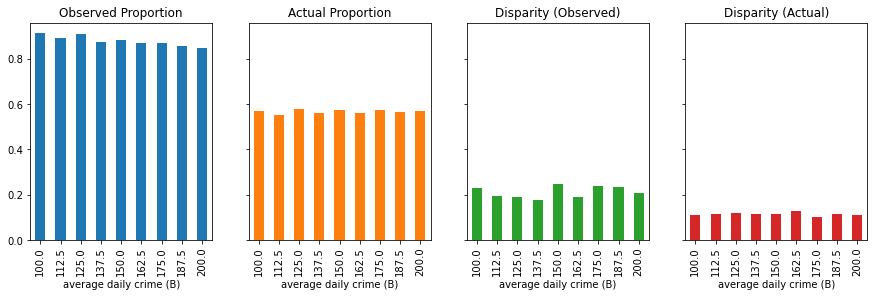

In [22]:
# visualize results
pd.DataFrame(results_2).groupby('average daily crime (B)').mean().plot(kind='bar', figsize=(15,4), subplots=True,
                                                                       layout=(1,4), legend=False, sharey=True)
plt.show()

Similarly, *the observed disparity is higher than the actual disparity*. This is due to the differences in scale between the observed proportion and actual proportion: *observed proportion is generally higher than the actual proportion*.

*The actual disparity is independent of the average daily crime in neighborhood B*. When we vary the daily crime in neighborhood *B*, the police officer will be send more often to neighborhood B. However, **in this scenario, consistently dispatching the officer to neighborhood B does not increase quality-of-service harm as the average daily crime rate goes up, because it is consistent with the relative number of crime**. 


## Concluding Remarks

As we have seen in this tutorial, historical biases can be amplified by prediction models through reinforcing feedback loops. 

### Design Choices
When we go back to the CRISP-DM process, we can see how different design choices in the development pipeline contribute to this issue.
* *Problem Formulation*. We formulated the problem as a prediction model, not taking into account how the predictions will be used to make decisions.
* *Data Collection.* The output of our model directly influences new data collection, resulting in the feedback loop. The underlying issue here is a construct validity bias of discovered crime, which can be a biased proxy for *actual crime*.
* *Modeling.* The modeling approach does not account for possible biases.
* *Evaluation.* Optimizing only for (observed!) accuracy can be insufficient.
* *Deployment.* This is where the actual disparities get amplified! The way we use the output of our model is crucial to avoid a feedback loop. 

### Mitigation Strategies
These considerations also give clues for identifying mitigation strategies.
* At the *problem formulation* level, we can approach predictive policing as a reinforcement learning problem rather than a prediction problem. That is, we can try to learn the best possible dispatching policy, with fairness constraints that avoid the feedback loop. We can directly optimize the policy (which is where the impact occurs), rather than the predictions.
* At the *data collection level*, we can try to reduce the construct validity bias across groups. One way to achieve this, is to estimate the *actual* crime rate in a neighborhood. To avoid racial bias present in predictive policing practices, we can embark on a (collaborative) research project with experts on the subject matter, such as criminologists.
* At the *data preparation* level, we can decide to leave some of the observed crime out of the data, proportional to the number of police officers that were dispatched to a particular area. Although this approach can alleviate the feedback loop, it does not solve the underlying bias: police officers may still act upon (unconscious) racial bias.
* At the *model* level, we can add randomization to the prediction model. In this way, we can reduce the effect of the reinforcing feedback loop. Again, this mostly alleviates the feedback loop, but randomly dispatching police officers may not help to decrease racial bias.
* At the *deployment* level, we can observe how observed crime rates change over time and be mindful of possible instances of the feedback loop. Is crime really going up, or does it just look like it does?

### Discussion Points & Exercises
* In Experiment Set 2, we have seen that the performance disparity is independent of the actual crime rate. Would our conclusion be the same if we had considered a notion of fairness related to allocation harm?
* In Experiment Set 1 and 2, we only changed one variable at the time. In a third experiment, vary both historic discovery rate and underlying crime rates, at the same time. Can you explain the results?
* (*Advanced*) Extend the simulation with more neighborhoods and/or agents and re-run some of the experiments. Does this change your results?
* (*Advanced*) In the current simulation, the crime rate is constant over time. Extend the simulation to include crime rates that change over time. Re-run the experiments. Can you explain the results?
* (*Advanced*) In the current simulation, we only considered one type of crime. In reality, different types of crime may occur. In particular, the observed crime rate may be different for more serious crimes and lighter crimes. When no distinction is made between these types of crimes, this can result in an instance of Simpson's paradox, where disparities in crime rates can actually be explained by the seriousness of the crime. As an exercise, you can extend the current simulation to explore different types of incidents.